# Introduction to Implicit Time Integration - Diffusion

In [1]:
# Basic modules and graphics settings
%matplotlib inline 
import numpy  
import math                     
from matplotlib import pyplot    
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

## Some basic explicit time integration

In [5]:
# Specifit modules
from diffus import BFDResidual      # Diffusion backward finite difference residual
#from timeint import explicitEuler # Time integration procedures

# Input parameters
nx = 41      # number of points in space
tt = 0.1    # total time of simulation
lx = 2.      # 1D domain length 
nu  = 0.3    # Diffusivity
sigma = .2   # sigma <= 0.5

# Discretization
dx = lx/(nx-1)                 # grid interval size in space
x  = numpy.linspace(0.,lx,nx)  # spatial grid
dt = (sigma*dx**2)/nu             
nt = int(math.floor(tt/dt))    # Computes the numper of time steps required to reach tt

# Initial condition
u = numpy.ones(nx) 
lbound = numpy.where(x >= 0.5)
ubound = numpy.where(x <= 1)
u[numpy.intersect1d(lbound, ubound)] = 2.

def explicitEuler(u, nt, dt, dx):

    # Inicializa os resultados com dimensoes nt X nx
    un = numpy.zeros( (nt,len(u)) )
    # Copia o u inicial em todas as linhas
    un[:,:] = u.copy()

    for t in range(1, nt):  
        Residual = BFDResidual(nu, dx, u)
        un[t,1:-1] = u[1:-1] + dt*Residual # u_{n+1}
        un[t, 0] = u[ 0]    # C.C.
        un[t,-1] = u[-1]    # C.C
        u = un[t].copy()    # u_{n+1} -> u_n
        
    return un

un = explicitEuler(u, nt, dt, dx)



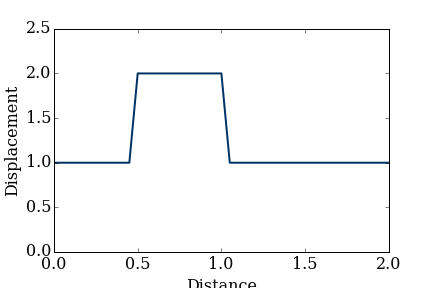
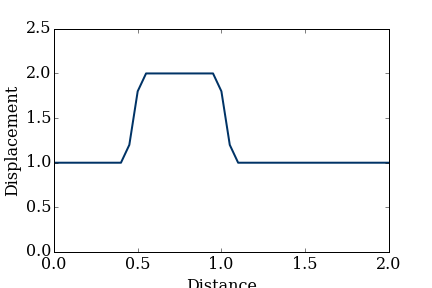
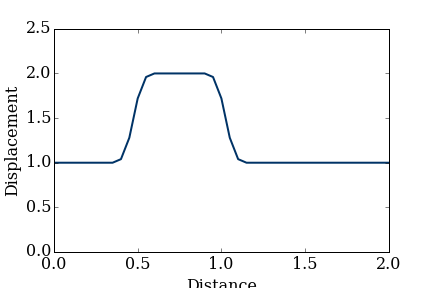
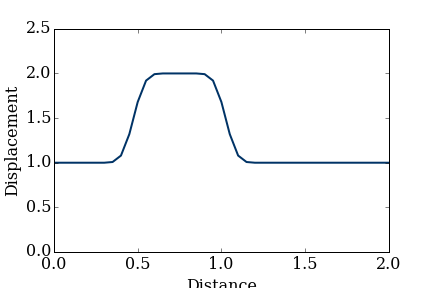
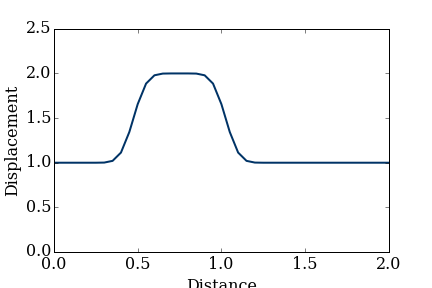
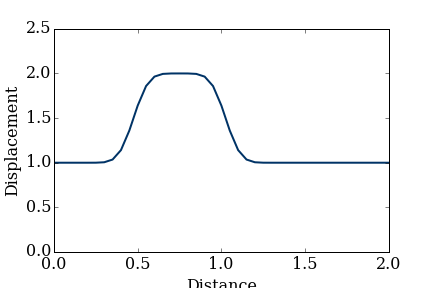
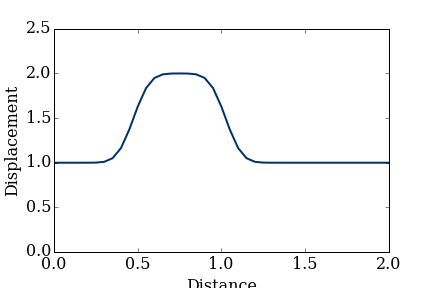
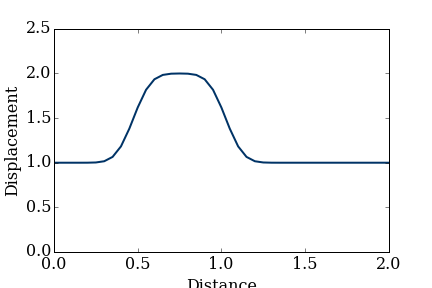
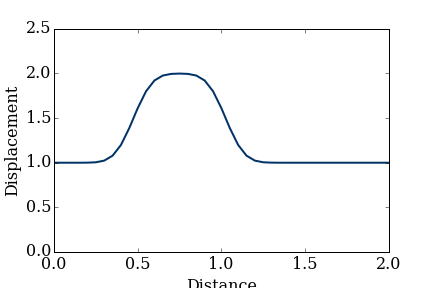
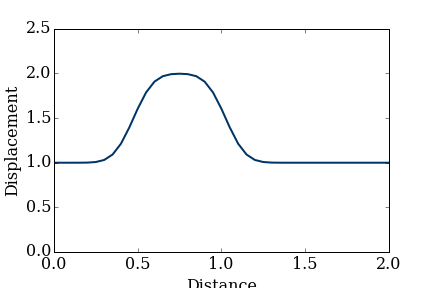
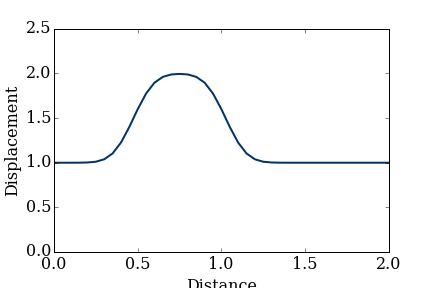
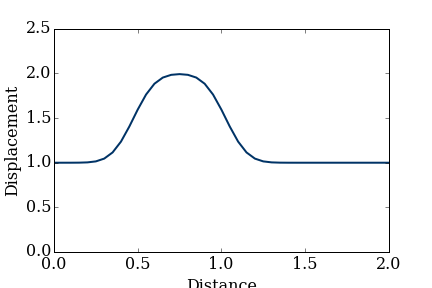
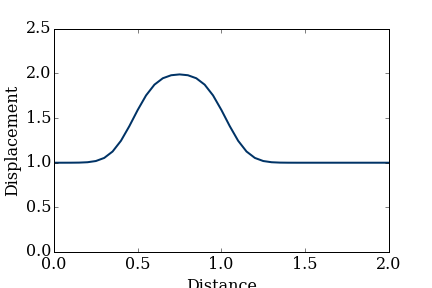
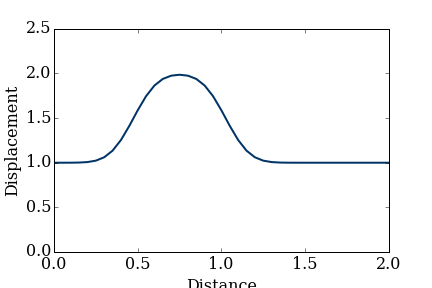
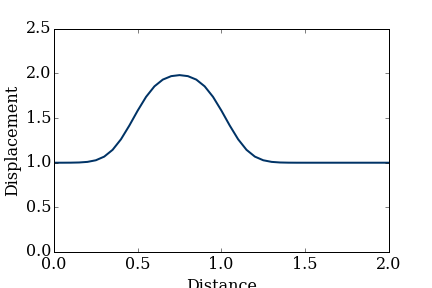
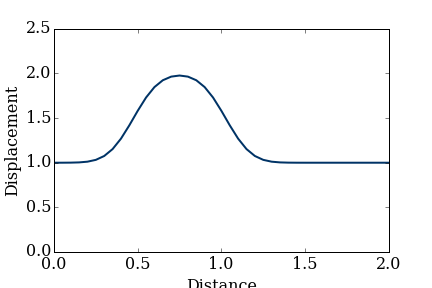
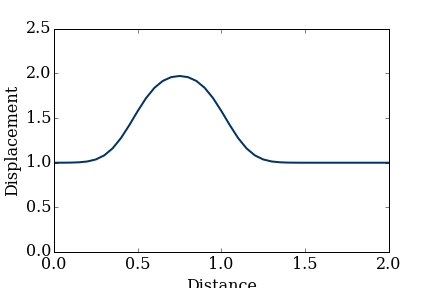
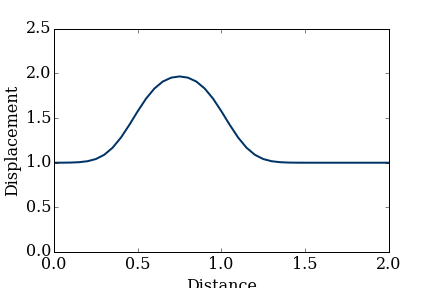
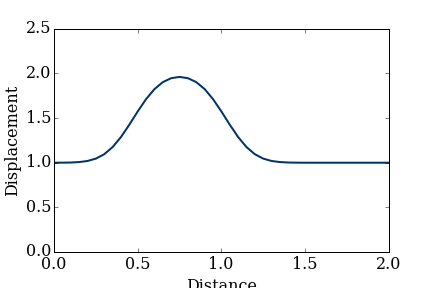
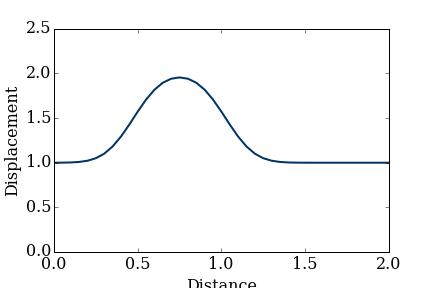
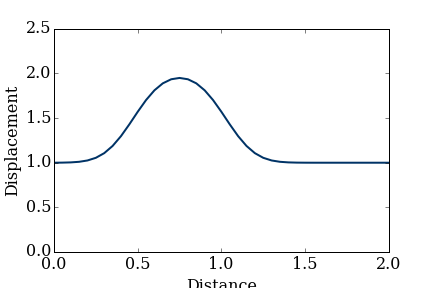
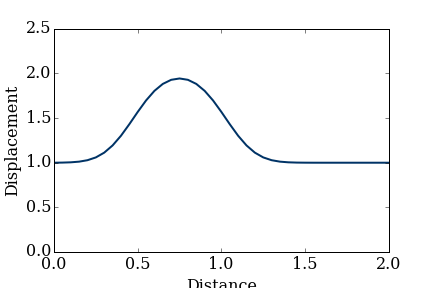
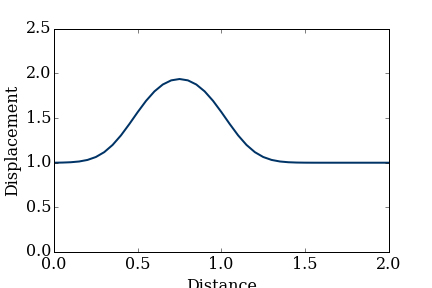
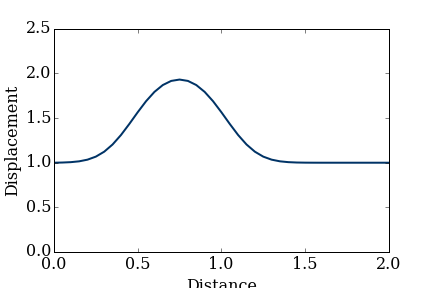
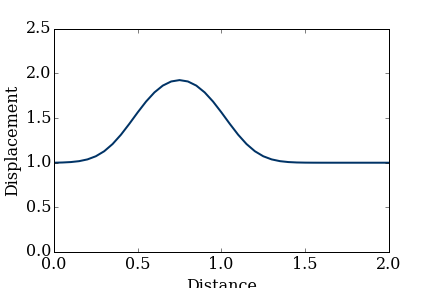
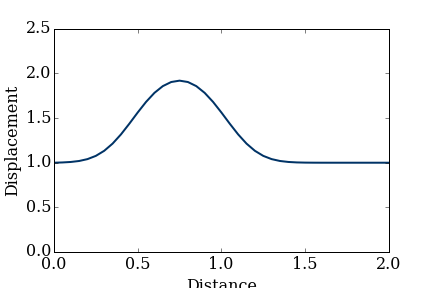
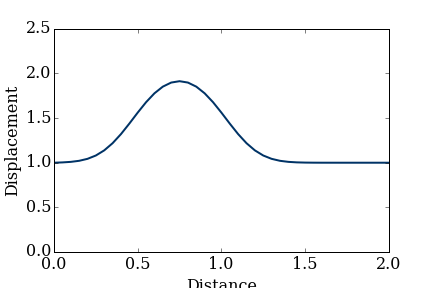
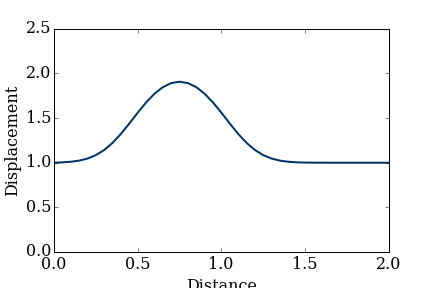
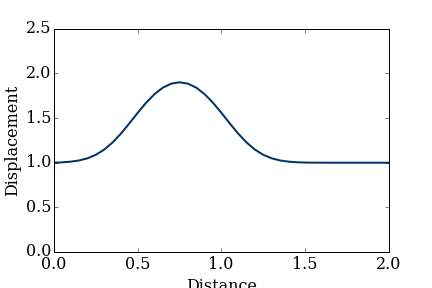
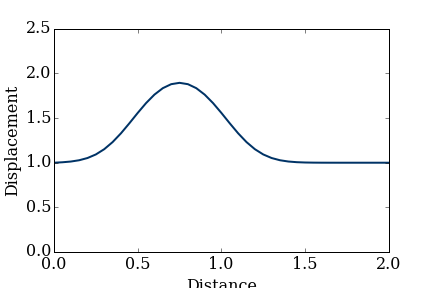
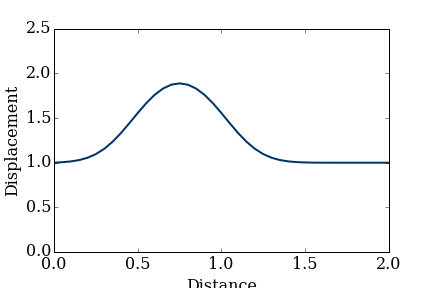
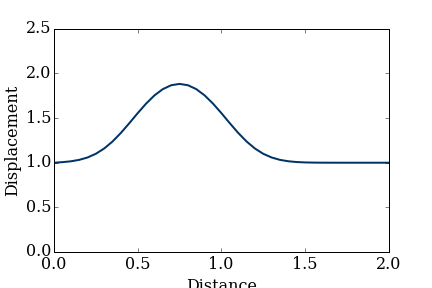
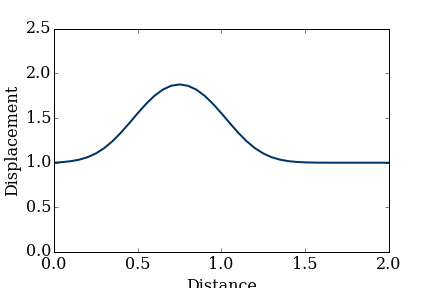
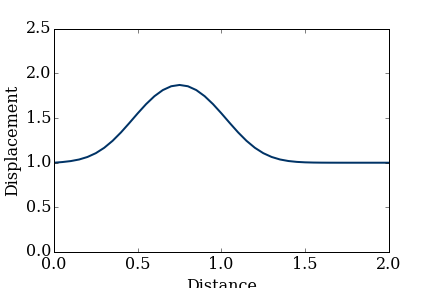
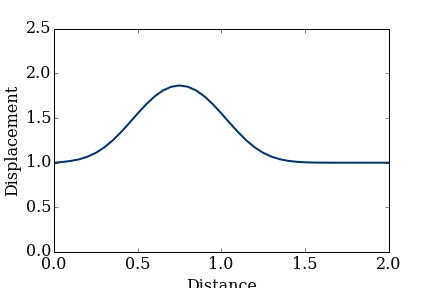
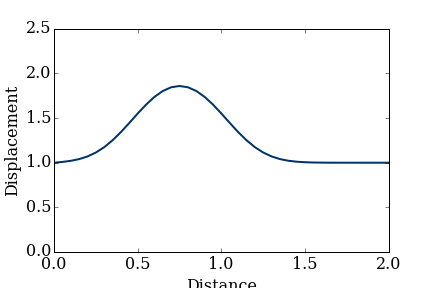
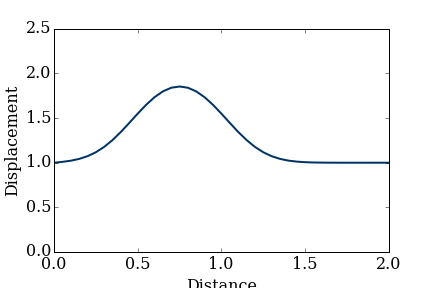
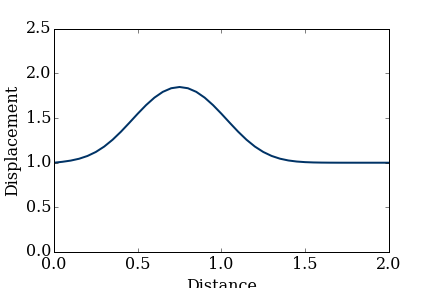
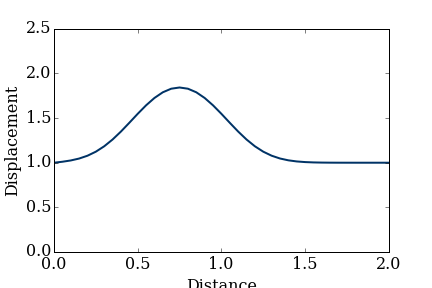
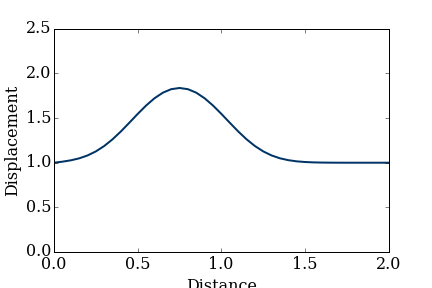
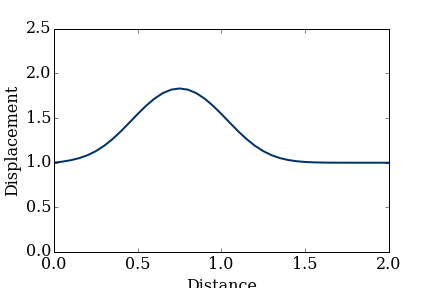
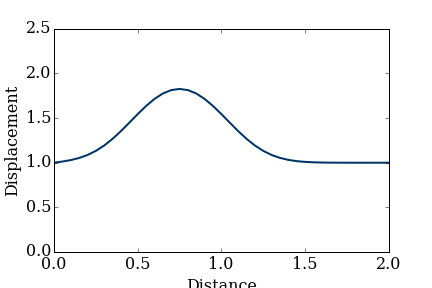
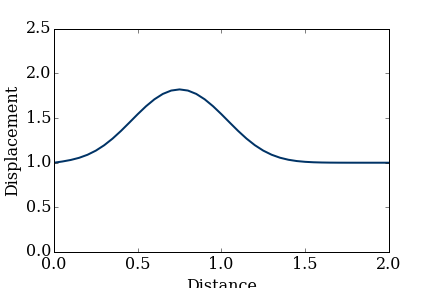
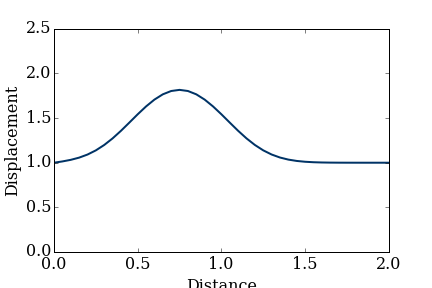
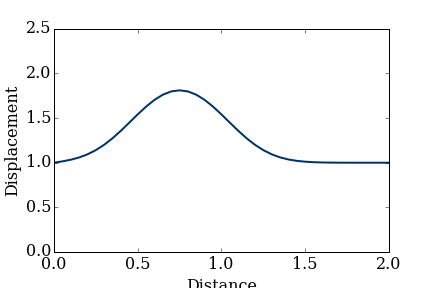
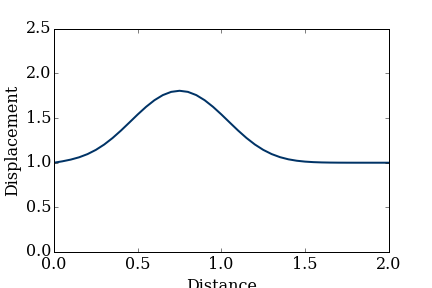
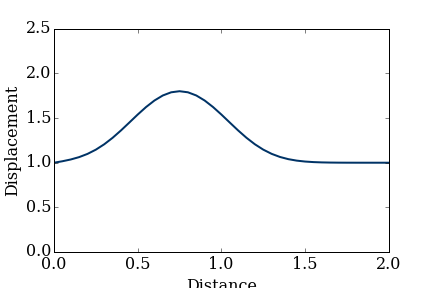
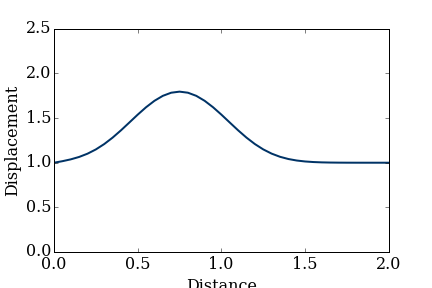
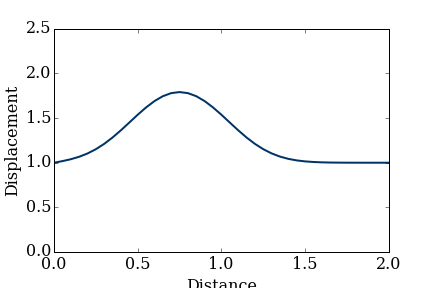
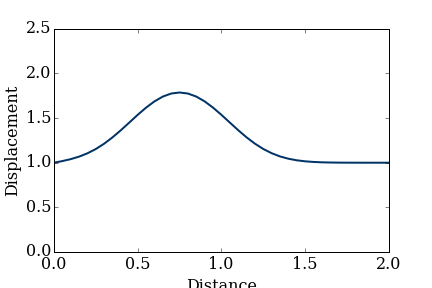
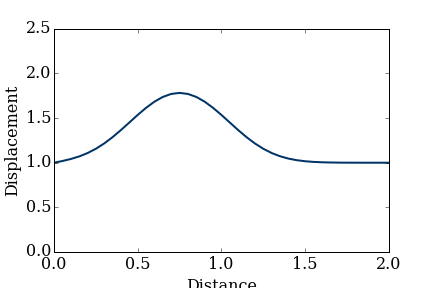
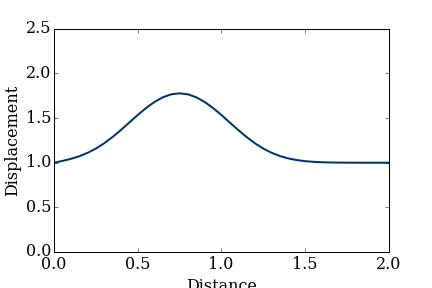
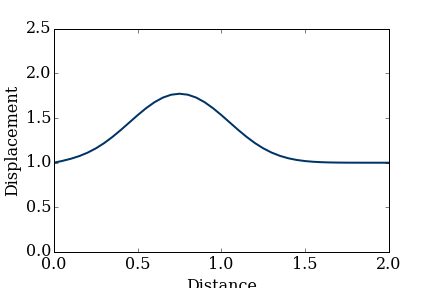
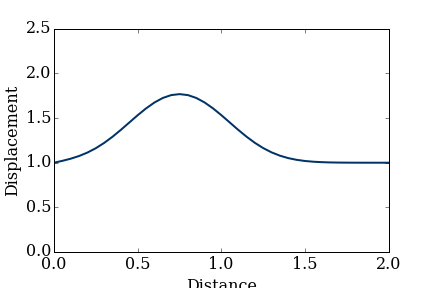
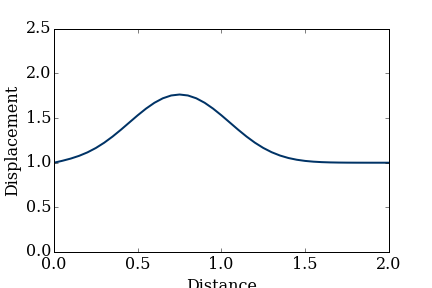
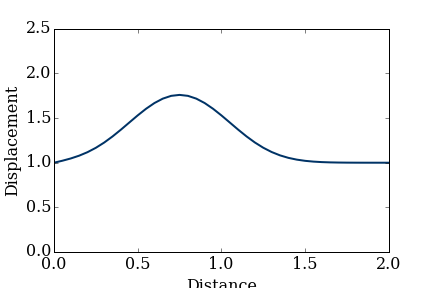
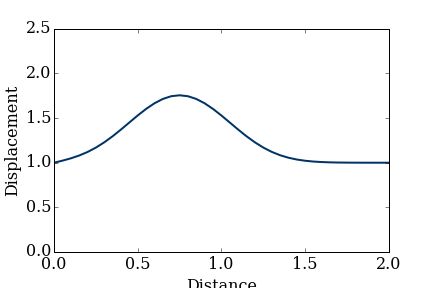
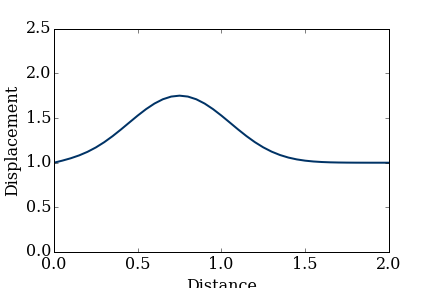
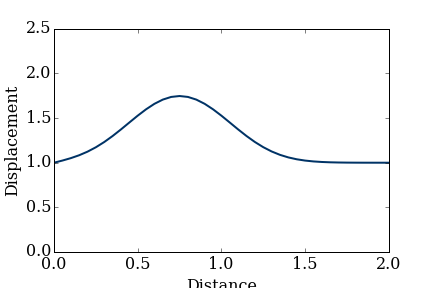

In [6]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,lx),ylim=(0,2.5),xlabel=('Distance'),ylabel=('Displacement'));
line, = ax.plot([],[],color='#003366', lw=2);

def animate(data):
    x = numpy.linspace(0,lx,nx)
    y = data
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=un, interval=50)
display_animation(anim, default_mode='once')

## Backward Euler Implicit Time Integration

In [21]:
# Specifit modules
from diffus import BFDResidual
from diffus import DuBFDResidual

# Input parameters
nx = 61      # number of points in space
tt = 0.1     # total time of simulation
lx = 2.      # 1D domain length 
nu  = 0.3    # Diffusivity
sigma = .7   # sigma <= 0.5

# Discretization
dx = lx/(nx-1)                 # grid interval size in space
x  = numpy.linspace(0.,lx,nx)  # spatial grid
dt = (sigma*dx**2)/nu             
nt = int(math.floor(tt/dt))    # Computes the numper of time steps required to reach tt

# Initial condition
u = numpy.ones(nx) 
lbound = numpy.where(x >= 0.5)
ubound = numpy.where(x <= 1)
u[numpy.intersect1d(lbound, ubound)] = 2

def implicitEuler(u, nt, dt, dx):

    # Inicializa os resultados com dimensoes nt X nx
    un = numpy.zeros( (nt,len(u)) )
    # Copia o u inicial em todas as linhas
    un[:,:] = u.copy()
    # Delta_u
    du = numpy.zeros(len(u))

    for t in range(1, nt):  
        # Initial test
        Residual    = BFDResidual(nu, dx, u) # Already [-1,1], check diffus.py
        Du_Residual = DuBFDResidual(nu, dx, u)                
        A = (1./dt)*numpy.eye(len(u)) - Du_Residual
        b = Residual 
        du[1:-1] = numpy.linalg.solve( A[1:-1,1:-1],b ) 
        err = numpy.linalg.norm(du[1:-1])
        u = u + du # for the linearized fully implicit, we stop here
        
        k = 0
        maxit = 5
        epsilon = 1.e-5
                
        while (err > epsilon) and (k < maxit):
            k = k+1
            Residual    = BFDResidual(nu, dx, u) # Already [-1,1], check diffus.py
            Du_Residual = DuBFDResidual(nu, dx, u)                
            A = (1./dt)*numpy.eye(len(u)) - Du_Residual
            b = Residual - (1./dt)*(u[1:-1] - un[t-1,1:-1])
            du[1:-1] = numpy.linalg.solve( A[1:-1,1:-1],b )
            err = numpy.linalg.norm(du[1:-1])
            u = u + du
            
        print("Time step = ", t," -> Number of LSS = ", k+1, " -> ||du|| = ", err)
        
        un[t,1:] = u[1:]    # u_{n+1}
        un[t, 0] = u[ 0]    # C.C.
        un[t,-1] = u[-1]    # C.C
        
    return un

un = implicitEuler(u, nt, dt, dx)

Time step =  1  -> Number of LSS =  2  -> ||du|| =  5.37674100737e-16
Time step =  2  -> Number of LSS =  2  -> ||du|| =  5.09258637125e-16
Time step =  3  -> Number of LSS =  2  -> ||du|| =  5.71885292577e-16
Time step =  4  -> Number of LSS =  2  -> ||du|| =  5.1935022369e-16
Time step =  5  -> Number of LSS =  2  -> ||du|| =  4.74674576316e-16
Time step =  6  -> Number of LSS =  2  -> ||du|| =  4.87479734821e-16
Time step =  7  -> Number of LSS =  2  -> ||du|| =  4.83992865828e-16
Time step =  8  -> Number of LSS =  2  -> ||du|| =  4.83514384957e-16
Time step =  9  -> Number of LSS =  2  -> ||du|| =  5.22386485773e-16
Time step =  10  -> Number of LSS =  2  -> ||du|| =  4.93200998954e-16
Time step =  11  -> Number of LSS =  2  -> ||du|| =  4.49766589374e-16
Time step =  12  -> Number of LSS =  2  -> ||du|| =  4.64316802625e-16
Time step =  13  -> Number of LSS =  2  -> ||du|| =  5.02123691643e-16
Time step =  14  -> Number of LSS =  2  -> ||du|| =  4.98178683049e-16
Time step =  15 


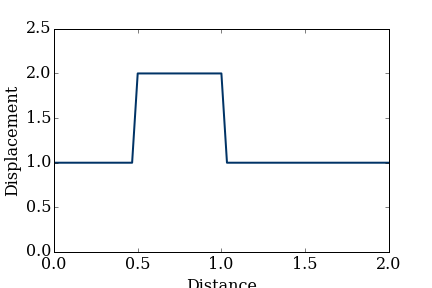
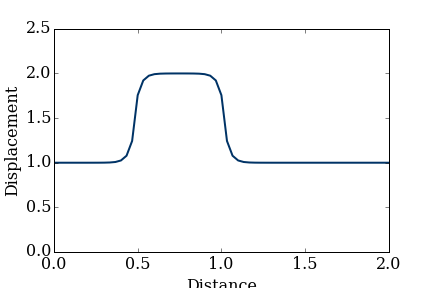
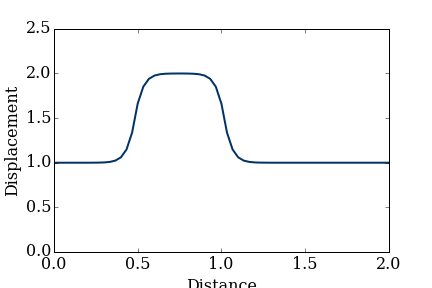
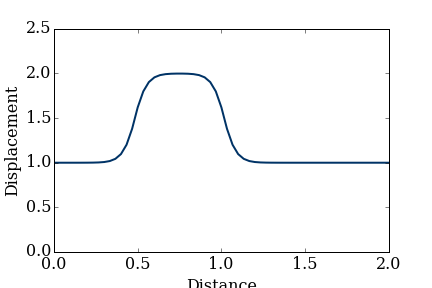
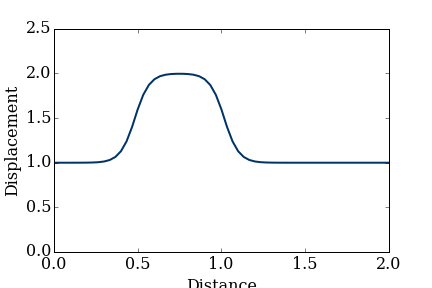
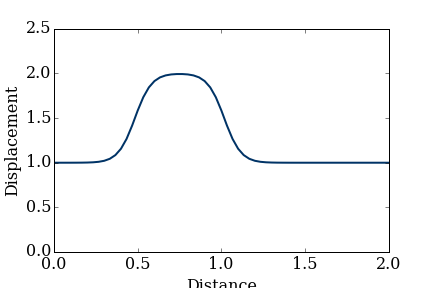
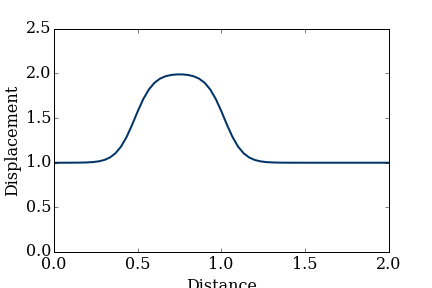
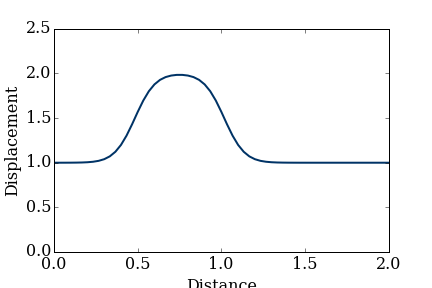
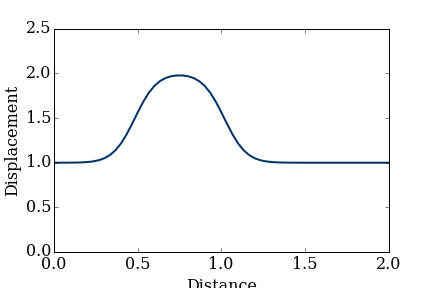
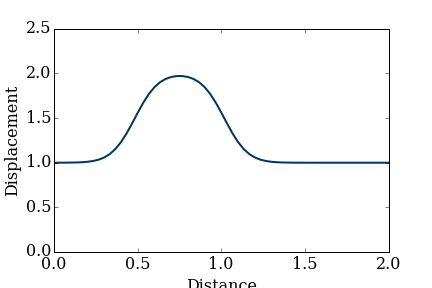
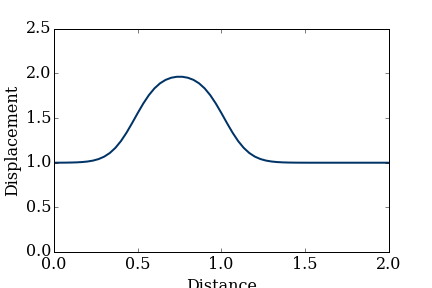
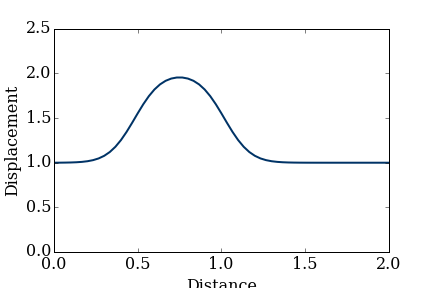
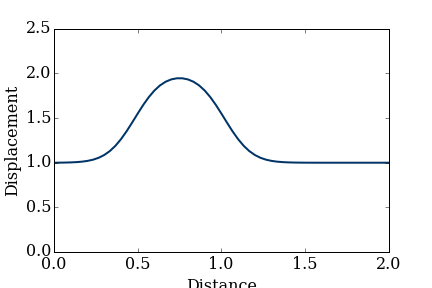
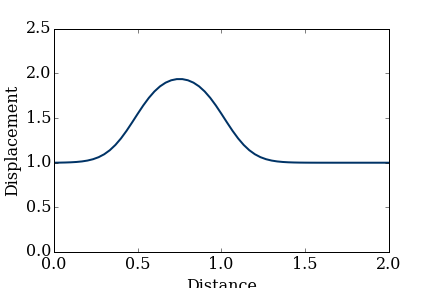
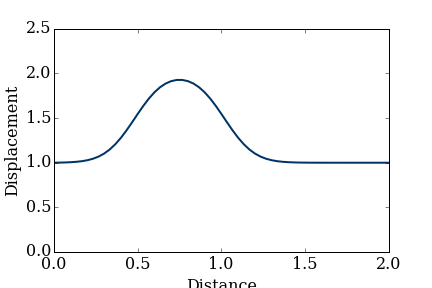
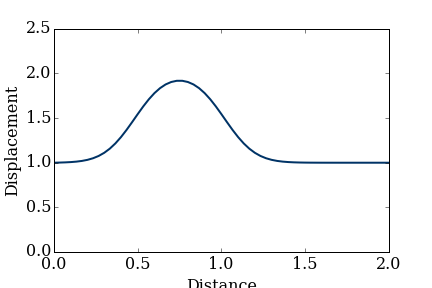
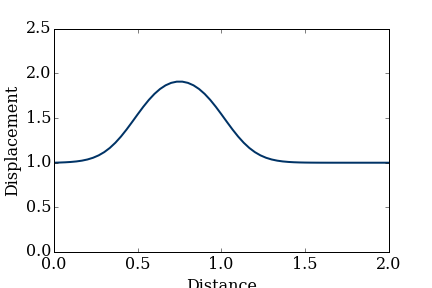
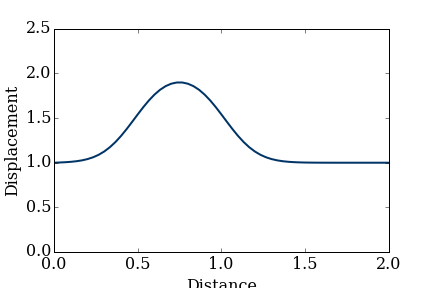
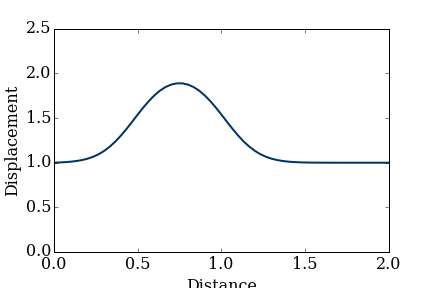
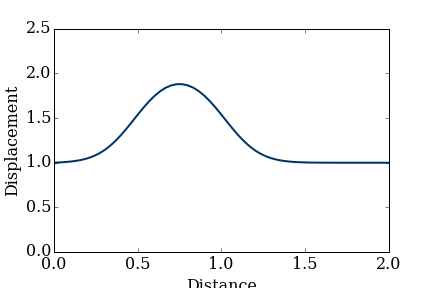
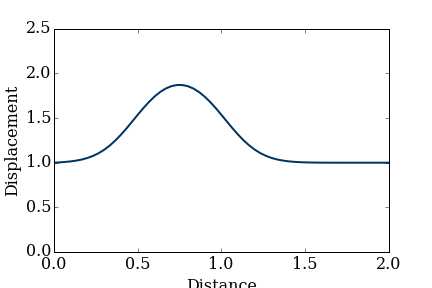
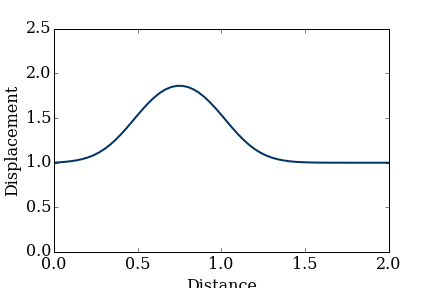
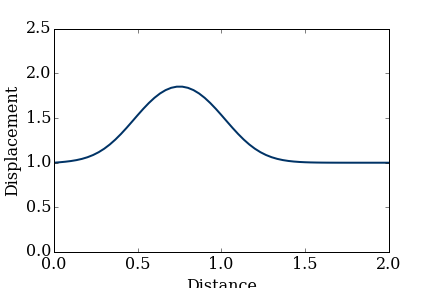
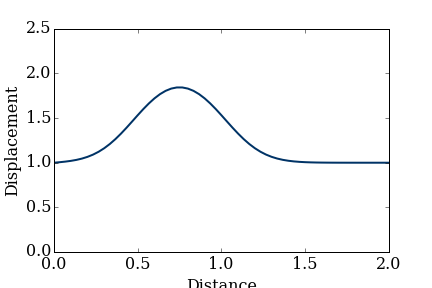
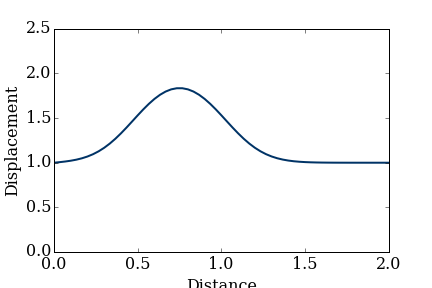
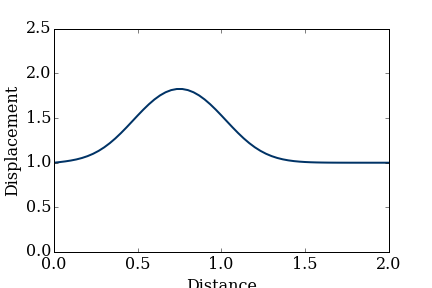
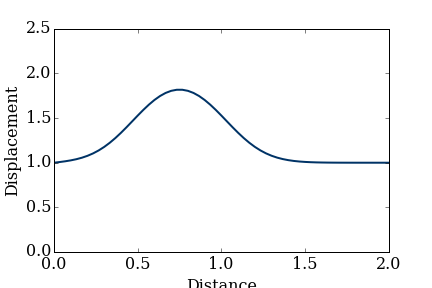
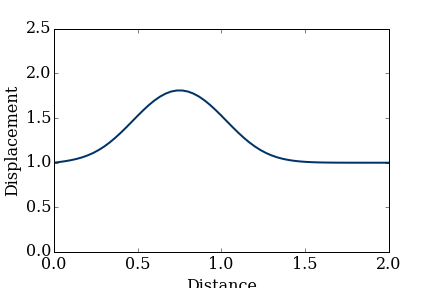
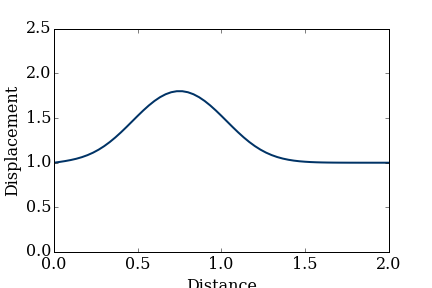
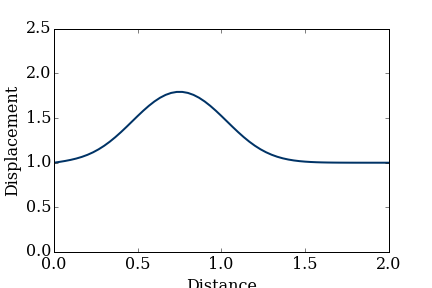
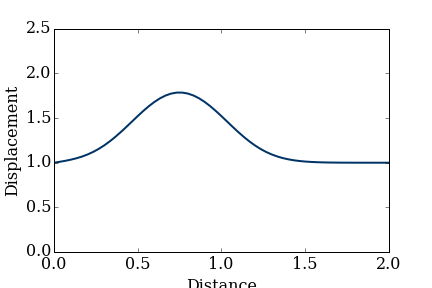
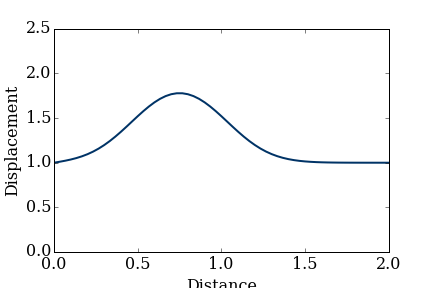
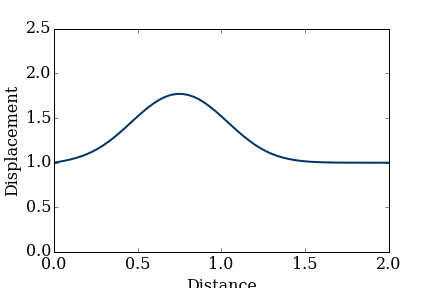
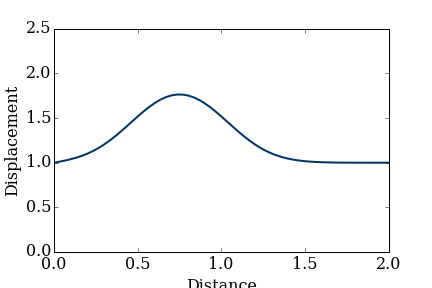
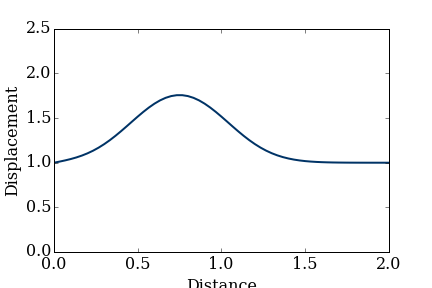
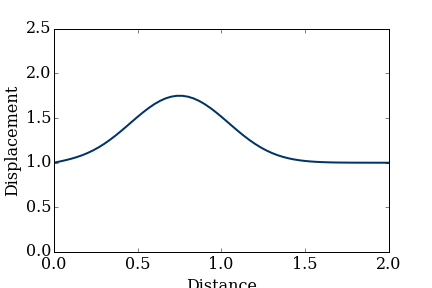
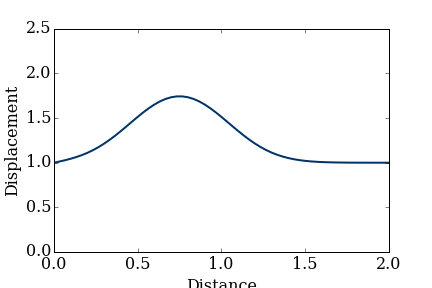
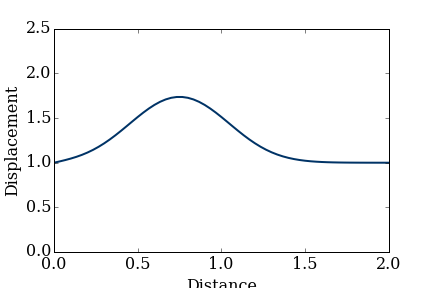

In [22]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,lx),ylim=(0,2.5),xlabel=('Distance'),ylabel=('Displacement'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=un, interval=50)
display_animation(anim, default_mode='once')